# Process Exported Flow-Slope Data
> Imports both the point and cell data and then calculates the slope difference, slope change rate, as well as the 1st and 2nd derivative of slope.

## Import necessary dependencies
* Geopandas - Managing spatial data
* ICESat2GroundingLineMigration.IceSatHDF5Unpacker - Hdf5 processing
* Matplotlib - Visualizations
* os - Filesystem info
* Math - math

In [1]:
import geopandas as gpd
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import shapely as sp

## Load GeoJSON files

Files are dated as `{type}-{system-time}.json`. Then these are read into a dataframe.

In [2]:
file = "RAW-1680386657.7548196.json"
cellfile = "CELL-1680386735.4628315.json"

data = gpd.read_file(f"Saves/{file}")
celldata = gpd.read_file(f"Saves/{cellfile}")

file2 = "RAW-1680490874.399847.json"
cellfile2 = "CELL-1680490953.3805711.json"

data2 = gpd.read_file(f"Saves/{file2}")
celldata2 = gpd.read_file(f"Saves/{cellfile2}")

## Show data

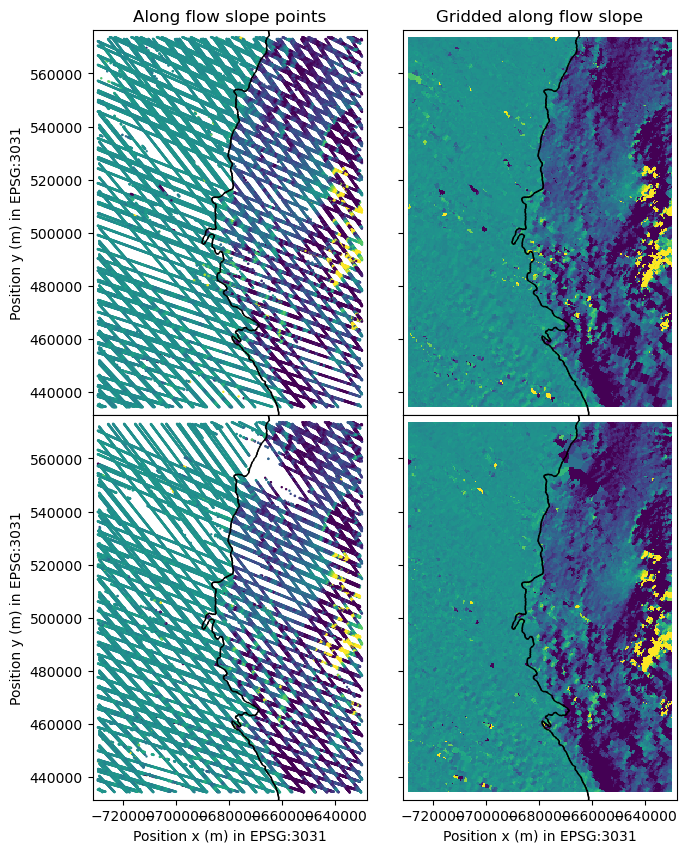

In [3]:
imbuffsc = 0.02

ylim = (data["geometry"].total_bounds[1], data["geometry"].total_bounds[3])
xlim = (data["geometry"].total_bounds[0], data["geometry"].total_bounds[2])

basemap = unpack.Basemap("BackgroundData/ATA_adm0.shp")
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 10))

plt.subplots_adjust(wspace=0, hspace=0)

ax[0,0].set_ylabel("Position y (m) in EPSG:3031")
ax[1,0].set_ylabel("Position y (m) in EPSG:3031")
ax[1,0].set_xlabel("Position x (m) in EPSG:3031")
ax[1,1].set_xlabel("Position x (m) in EPSG:3031")

ax[0,0].set_title("Along flow slope points")
ax[0,1].set_title("Gridded along flow slope")

data.plot(ax=ax[0,0], edgecolor="none", vmax=0.02, vmin=-0.02, column="slope", markersize=3)
basemap.basemap_gpd.plot(ax=ax[0,0], color="none", edgecolor="black")

celldata.plot(ax=ax[0,1], edgecolor="none", vmax=0.02, vmin=-0.02, column="slope", markersize=3)
basemap.basemap_gpd.plot(ax=ax[0,1], color="none", edgecolor="black")

data2.plot(ax=ax[1,0], edgecolor="none", vmax=0.02, vmin=-0.02, column="slope", markersize=3)
basemap.basemap_gpd.plot(ax=ax[1,0], color="none", edgecolor="black")

celldata2.plot(ax=ax[1,1], edgecolor="none", vmax=0.02, vmin=-0.02, column="slope", markersize=3)
basemap.basemap_gpd.plot(ax=ax[1,1], color="none", edgecolor="black")

plt.xlim(xlim[0]-abs(imbuffsc*(xlim[1]-xlim[0])), xlim[1]+abs(imbuffsc*(xlim[1]-xlim[0])))
plt.ylim(ylim[0]-abs(imbuffsc*(ylim[1]-ylim[0])), ylim[1]+abs(imbuffsc*(ylim[1]-ylim[0])))

plt.show()

## Bilinear Interpolation?

***Oh god it's slow*** - not anymore tho

### 1st convert to np for ease of processing

In [4]:
def raw_to_np(gdf):
    bounds = gdf.total_bounds
    xmin, xmax = bounds[0], bounds[2]
    ymin, ymax = bounds[1], bounds[3]
    xsize, ysize = int((xmax - xmin) / 450), int((ymax - ymin) / 450)
    slopes, angles = np.zeros((ysize, xsize)), np.zeros((ysize, xsize))
    slopes[:,:], angles[:,:] = np.nan, np.nan
    length = len(gdf)
    for i, row in gdf.iterrows():
        print(f"{i + 1}/{length}", end="\r")
        x, y = row["geometry"].xy
        x = x.tolist()
        y = y.tolist()
        ix, iy = int((x - xmin) / 450), int((y - ymin) / 450)
        try:
            slopes[iy, ix] = row["slope"]
            angles[iy, ix] = row["angle"]
        except IndexError:
            pass
    return slopes, angles

In [5]:
raw_slopes, raw_angles = raw_to_np(data)

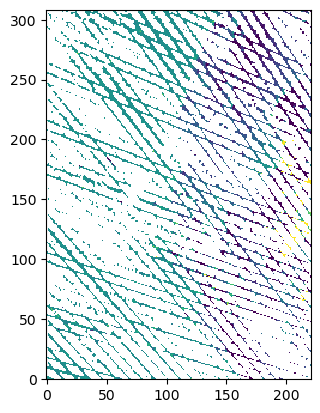

In [6]:
plt.imshow(raw_slopes, vmin = -0.02, vmax = 0.02, origin = "lower")
plt.show()

In [7]:
def basic_interpolation(arr, max_reach = 30):
    
    xdim, ydim = arr.shape[1], arr.shape[0]
    
    out = np.zeros(arr.shape)
    out[:,:] = np.nan
    
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            
            print(f"{ydim * i + j}/{xdim * ydim}", end="\r")
            
            if np.isnan(arr[i, j]) == False:
                out[i, j] = arr[i, j]
                
            else:
                vals, reachs = [], []
                # scan in + y
                reach = 1
                while reach <= max_reach:
                    if i + reach < ydim and np.isnan(arr[i + reach, j]) == False:
                        vals.append(arr[i + reach, j])
                        reachs.append(reach)
                        break
                    reach += 1
                # scan in +x
                reach = 1
                while reach <= max_reach:
                    if j + reach < xdim and np.isnan(arr[i, j + reach]) == False:
                        vals.append(arr[i, j + reach])
                        reachs.append(reach)
                        break
                    reach += 1
                # scan in -y
                reach = -1
                while abs(reach) <= max_reach:
                    if i + reach > 0 and np.isnan(arr[i + reach, j]) == False:
                        vals.append(arr[i + reach, j])
                        reachs.append(abs(reach))
                        break
                    reach -= 1
                # scan in -x
                reach = -1
                while abs(reach) <= max_reach:
                    if j + reach > 0 and np.isnan(arr[i, j + reach]) == False:
                        vals.append(arr[i, j + reach])
                        reachs.append(abs(reach))
                        break
                    reach -= 1
                if len(vals) > 0:
                    vals, reachs = np.array(vals), np.array(reachs)
                    reachs = (max_reach) - reachs
                    out[i, j] = np.sum(vals * (reachs / np.sum(reachs)))
    
    return out
    

In [8]:
interpolated = basic_interpolation(raw_slopes)

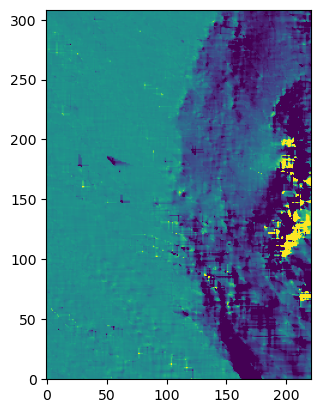

In [9]:
plt.imshow(interpolated, vmin = -0.02, vmax = 0.02, origin = "lower")
plt.show()

## Apply overlay to find the difference

* Due to the magnitude of the grid this operation takes quite a long time.
* Additionally, due to the fact that a grid is being used along with the intersection parameter, the edges of each cell are also created as a polygon. This polygon then has an invalid geometry, so it is detected and then removed. This consumes a lot of compute time, however there doesn't seem to be a simple solution to fix this issue.

In [4]:
overlaid = gpd.overlay(celldata, celldata2, how="intersection")

/tmp/ipykernel_100/2217023953.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 4182105 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlaid = gpd.overlay(celldata, celldata2, how="intersection")


In [5]:
overlaid.describe()

,angle_left_1,angle_err_1,index_right_1,slope_1,angle_right_1,azumith_in_xy_1,dh_fit_dx_1,dh_fit_dy_1,date_time_1,along_track_dist_1,angle_left_2,angle_err_2,index_right_2,slope_2,angle_right_2,azumith_in_xy_2,dh_fit_dx_2,dh_fit_dy_2,date_time_2,along_track_dist_2
count,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,6.314100e+05,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,631410.000000,6.314100e+05,631410.000000
mean,-0.636034,0.046589,68651.552950,-0.008355,-0.635827,-0.631148,-0.006839,0.000913,6.749351e+07,50.011710,-0.636034,0.046589,65190.435973,-0.008307,-0.635910,-0.637835,-0.006916,-0.001736,9.911994e+07,48.410284
std,0.702481,0.102175,39654.845911,0.028032,0.702704,0.275343,0.038334,0.259761,2.289582e+06,36.522123,0.702481,0.102175,37233.099874,0.028126,0.702563,0.273471,0.037201,0.152877,2.335080e+06,36.619375
min,-1.570730,0.001176,0.000000,-0.845655,-1.570730,-1.008016,-1.730768,-0.987219,6.332662e+07,0.777092,-1.570730,0.001176,0.000000,-0.707656,-1.570730,-1.009196,-1.328765,-0.960901,9.492285e+07,0.773194
25%,-1.083090,0.002439,35320.000000,-0.012925,-1.082824,-0.909293,-0.011845,-0.007314,6.582718e+07,19.255702,-1.083090,0.002439,34989.000000,-0.013005,-1.083129,-0.907217,-0.011977,-0.007339,9.721434e+07,17.888389
50%,-0.867348,0.018233,72577.500000,-0.003278,-0.866547,-0.457185,-0.003320,-0.000934,6.784661e+07,42.885879,-0.867348,0.018233,64914.000000,-0.003264,-0.866504,-0.818711,-0.003523,-0.000886,9.936980e+07,39.651750
75%,-0.376693,0.053141,103504.000000,0.000059,-0.376796,-0.355270,0.000697,0.000863,6.965698e+07,75.057720,-0.376693,0.053141,97600.000000,0.000080,-0.376554,-0.363714,0.000702,0.000991,1.010953e+08,73.896410
max,1.570746,15.968276,132948.000000,0.815905,1.570746,-0.265962,1.786461,22.111189,7.082831e+07,161.799848,1.570746,15.968276,128575.000000,0.692556,1.570571,-0.230590,1.434839,20.332563,1.024246e+08,161.799879


## Calculate difference

In [6]:
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

overlaid["diff"] = overlaid["slope_2"] - overlaid["slope_1"] 
overlaid["rate"] = (overlaid["diff"]) / (overlaid["date_time_2"] - overlaid["date_time_1"])

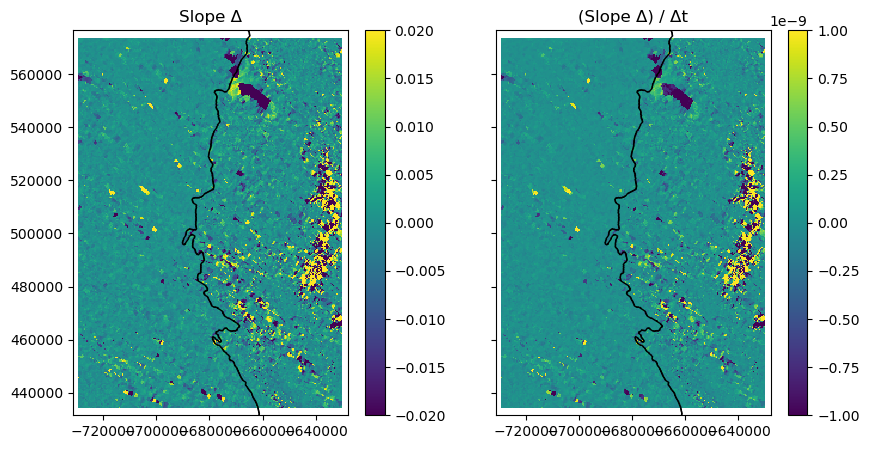

In [8]:
basemap = unpack.Basemap("BackgroundData/ATA_adm0.shp")
fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
overlaid.plot(ax=ax[0], edgecolor="none", vmax=0.02, vmin=-0.02, column="diff", legend = True)
overlaid.plot(ax=ax[1], edgecolor="none", vmax=1e-9, vmin=-1e-9, column="rate", legend = True)
basemap.basemap_gpd.plot(ax=ax[0], color="none", edgecolor="black")
basemap.basemap_gpd.plot(ax=ax[1], color="none", edgecolor="black")
plt.xlim(xlim[0]-abs(imbuffsc*(xlim[1]-xlim[0])), xlim[1]+abs(imbuffsc*(xlim[1]-xlim[0])))
plt.ylim(ylim[0]-abs(imbuffsc*(ylim[1]-ylim[0])), ylim[1]+abs(imbuffsc*(ylim[1]-ylim[0])))
ax[0].set_title("Slope Δ")
ax[1].set_title("(Slope Δ) / Δt")
plt.show()

## What about the derivative of the slopes?

First need to convert all data to a np.ndarray for ease of use and to boost processing speed.

In [10]:
xmin, xmax = celldata["geometry"].total_bounds[0], celldata["geometry"].total_bounds[2]
ymin, ymax = celldata["geometry"].total_bounds[1], celldata["geometry"].total_bounds[3]
print(f"xmin:{xmin} xmax:{xmax} ymin:{ymin} ymax:{ymax}")
xsize = int((xmax - xmin) / 450)
ysize = int((ymax - ymin) / 450)

xmin:-729374.8984224187 xmax:-630000.0 ymin:434351.56494083966 ymax:573679.7964001412


### Coversion of GLine

- Clip gline polygon by study area
- Extract x and y verticies and turn into line

In [11]:
gline_clip = basemap.basemap_gpd.clip_by_rect(xlim[0], ylim[0], xlim[1], ylim[1])

In [12]:
gline_poly = gline_clip.iloc[0]

x, y = gline_poly.exterior.coords.xy
x, y = np.array(x.tolist()), np.array(y.tolist())

x, y = x / 450, y / 450
x, y = x - x.min(), y - y.min()
x, y = (xsize - x.max()) + x, (ysize - y.max()) + y

gline_xy = np.vstack((x,y))

In [13]:
def find_intersection(arr, y):
    for i in range(arr.shape[1] - 1):
        if y <= arr[1, i] and y >= arr[1, i + 1]:
            return (arr[0, i] + arr[0, i + 1]) / 2
        elif y >= arr[1, i] and y <= arr[1, i + 1]:
            return (arr[0, i] + arr[0, i + 1]) / 2

In [14]:
x_int_1 = find_intersection(gline_xy, 230)
x_int_2 = find_intersection(gline_xy, 280)
print(f"Int @ 230: {x_int_1} | Int @ 280: {x_int_2}")

Int @ 230: 112.47144363280654 | Int @ 280: 131.1678241558718


### Conversion of slope & angle array

Ungeoreferences the data for much faster processing. This can be done as the data is on a grid, and can be easily regeoreferenced later if needed.

In [15]:
def slopes_to_np(gdf):
    slopes = np.zeros((ysize, xsize))
    angles = np.zeros((ysize, xsize))
    length = len(gdf)
    for i, row in gdf.iterrows():
        print(f"{i}/{length}", end="\r")
        x, y = row["geometry"].exterior.coords.xy
        x = x.tolist()
        y = y.tolist()
        ix, iy = int((x[0] - xmin) / 450), int((y[0] - ymin) / 450)
        try:
            slopes[iy, ix] = row["slope"]
            angles[iy, ix] = row["angle_left"]
        except IndexError:
            pass
    return slopes, angles

In [17]:
slopes, angles = slopes_to_np(celldata)
slopes = interpolated

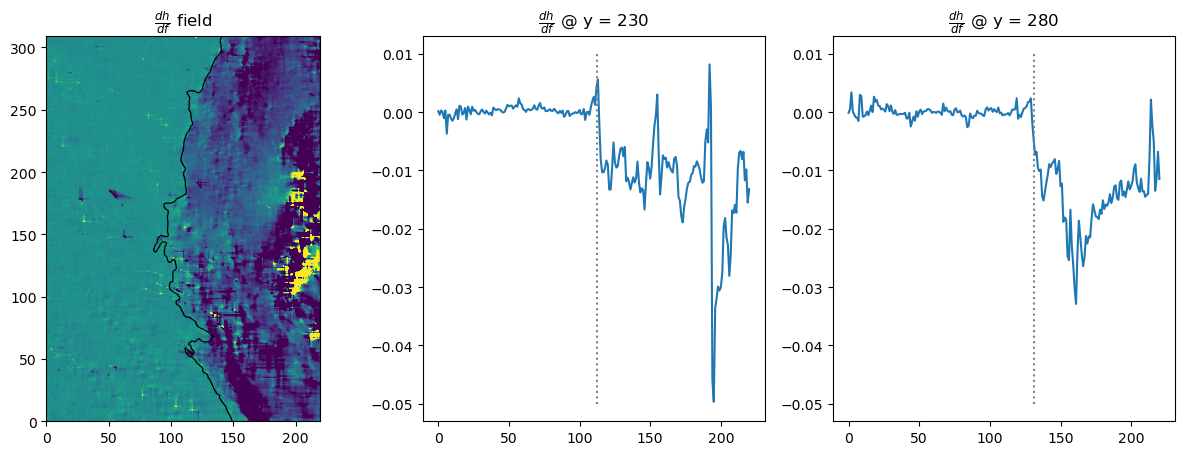

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].set_title(r'$\frac{dh}{df}$ field')
ax[0].imshow(slopes, vmin=-0.02, vmax=0.02)
ax[0].plot(gline_xy[0,:], gline_xy[1,:], c="black", linewidth=0.8)
ax[0].set_xlim(0, xsize)
ax[0].set_ylim(0, ysize)
ax[1].set_title(r"$\frac{dh}{df}$ @ y = 230")
ax[1].plot(range(slopes.shape[1]), slopes[230, :])
ax[1].vlines(x_int_1, ymin = -0.05, ymax = 0.01, linestyles = "dotted", color="gray")
ax[2].set_title(r"$\frac{dh}{df}$ @ y = 280")
ax[2].plot(range(slopes.shape[1]), slopes[280, :])
ax[2].vlines(x_int_2, ymin = -0.05, ymax = 0.01, linestyles = "dotted", color="gray")
plt.show()

In [19]:
def deriv_of_slopes(slopes, angles, width = 2):
    
    xdim = slopes.shape[1]
    ydim = slopes.shape[0]
    
    deriv = np.zeros(slopes.shape)
    
    for x in range(xdim):
        for y in range(ydim):
            
            print(f"{x * xdim}/{ydim * xdim}", end="\r")
            
            try:
                x_t1, y_t1 = int(x + width * math.cos(angles[y][x])), int(y + width * math.sin(angles[y][x]))
                x_t2, y_t2 = int(x + width * math.cos(angles[y][x] + math.pi / 2)), int(y + width * math.sin(angles[y][x] + math.pi / 2))

                deriv[y][x] =  (slopes[y_t1][x_t1] - slopes[y_t2][x_t2]) / (2 * 450)
                
            except IndexError:
                pass
            
    return deriv

In [20]:
deriv = deriv_of_slopes(slopes, angles)

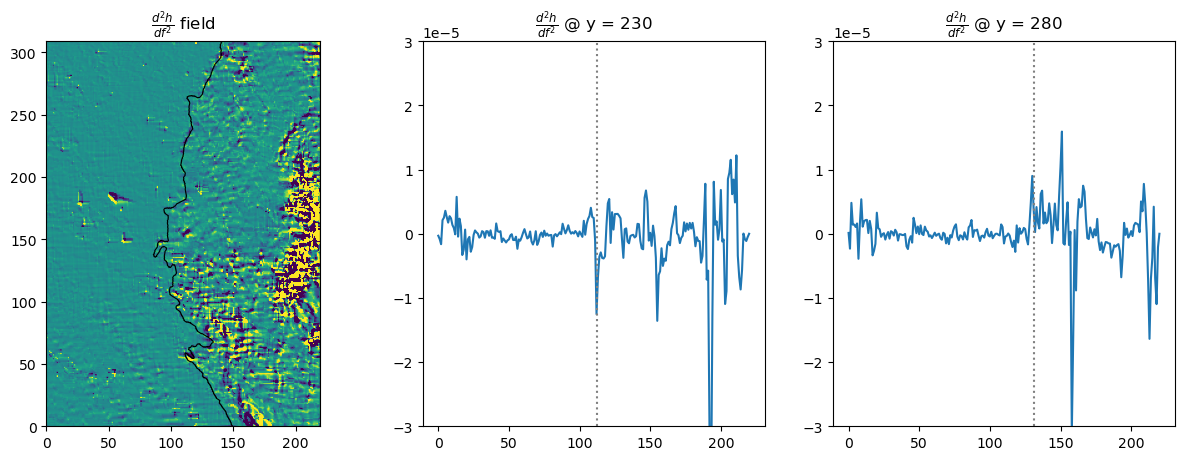

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].set_title(r"$\frac{d^2h}{df^2}$ field")
ax[0].imshow(deriv, vmin=-1.5e-5, vmax=1.5e-5)
ax[0].plot(gline_xy[0,:], gline_xy[1,:], c="black", linewidth=0.8)
ax[0].set_xlim(0, xsize)
ax[0].set_ylim(0, ysize)
ax[1].set_title(r"$\frac{d^2h}{df^2}$ @ y = 230")
ax[1].plot(range(deriv.shape[1]), deriv[230, :])
ax[1].set_ylim(-3e-5, 3e-5)
ax[1].vlines(x_int_1, ymin = -3e-5, ymax = 3e-5, linestyles = "dotted", color="gray")
ax[2].set_title(r"$\frac{d^2h}{df^2}$ @ y = 280")
ax[2].plot(range(deriv.shape[1]), deriv[280, :])
ax[2].vlines(x_int_2, ymin = -3e-5, ymax = 3e-5, linestyles = "dotted", color="gray")
ax[2].set_ylim(-3e-5, 3e-5)
plt.show()

In [26]:
deriv_2nd = deriv_of_slopes(deriv, angles)

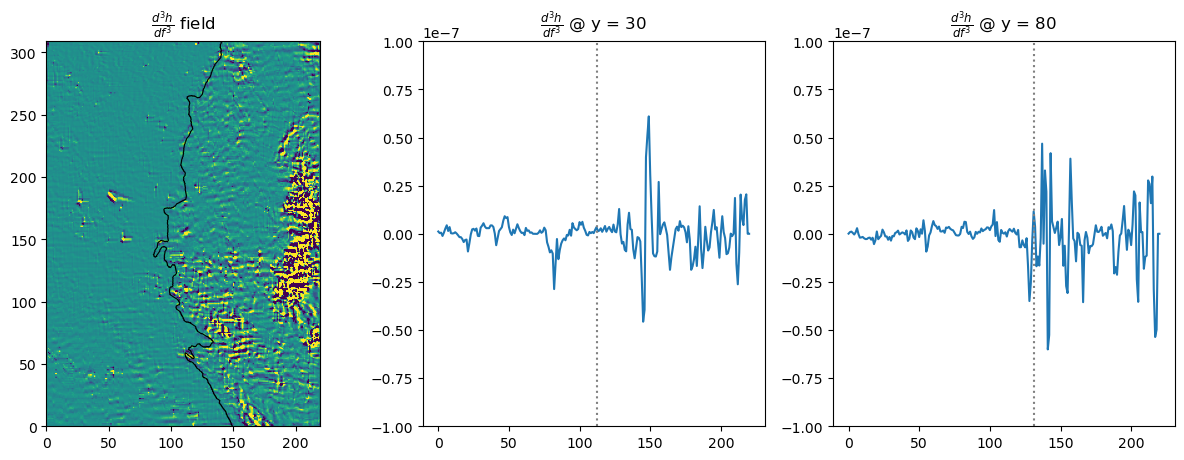

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].set_title(r"$\frac{d^3h}{df^3}$ field")
ax[0].imshow(deriv_2nd, vmin=-3e-8, vmax=3e-8)
ax[0].plot(gline_xy[0,:], gline_xy[1,:], c="black", linewidth=0.8)
ax[0].set_xlim(0, xsize)
ax[0].set_ylim(0, ysize)
ax[1].set_title(r"$\frac{d^3h}{df^3}$ @ y = 30")
ax[1].plot(range(deriv_2nd.shape[1]), deriv_2nd[30, :])
ax[1].set_ylim(-1e-7, 1e-7)
ax[1].vlines(x_int_1, ymin = -1e-7, ymax = 1e-7, linestyles = "dotted", color="gray")
ax[2].set_title(r"$\frac{d^3h}{df^3}$ @ y = 80")
ax[2].plot(range(deriv_2nd.shape[1]), deriv_2nd[80, :])
ax[2].set_ylim(-1e-7, 1e-7)
ax[2].vlines(x_int_2, ymin = -1e-7, ymax = 1e-7, linestyles = "dotted", color="gray")
plt.show()